In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import math
from scipy.integrate import odeint
import pandas as pd
from scipy import fftpack
from matplotlib.colors import LogNorm

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.

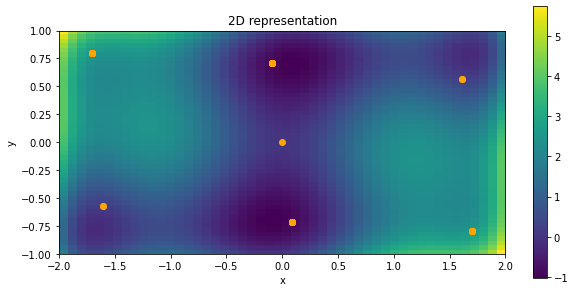

The function values of mins are:

-1.03163
-1.03163
-0.21546
2.10425
0.0
-0.21546
2.10425



For an initial guess of (x,y)=(0,0) we have:

      fun: 0.0
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 5.96046448e-08, -5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])


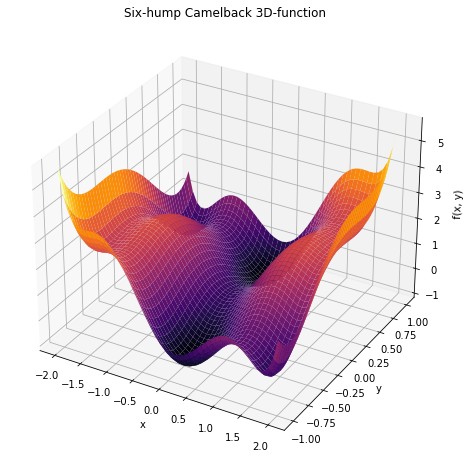

In [3]:
# six-hump camelback function
def f(X):
    x = X[0]
    y = X[1]
    return (4 - 2.1*pow(x,2) + pow(x,4)/3)* pow(x,2) + x*y +(4*pow(y,2) - 4)*pow(y,2)

# function to check if two minimas are equal or not
def areEquals(m1, m2):
    f1 = (math.isclose(m1.x[0], m2.x[0], abs_tol = 1e-05))
    f2 = (math.isclose(m1.x[1], m2.x[1], abs_tol = 1e-05))
    return f1 and f2

n = 100 # number of samples

# create the axes
x = np.linspace(-2,2)
y = np.linspace(-1,1)
xg, yg = np.meshgrid(x,y)

# plot
plt.figure(figsize=[10, 5])
plt.imshow(f([xg, yg]), extent=(-2,2,-1,1))
plt.colorbar()
plt.title('2D representation')
plt.xlabel('x')
plt.ylabel('y')

# search the minimums
minimums = []
prec = 0.25 # inspection precision
lenx = 4 # x = -2:2
leny = 2 # y = -1:1
for i in range(int(lenx/prec)+1):
    for j in range(int(leny/prec)+1):
        curr_guess = [-2 + prec*i , -1 + prec*j]
        minima = optimize.minimize(f, curr_guess)
        minimums.append(minima)
        
# print the found local mins
for i,m in enumerate(minimums):
    plt.scatter(m.x[0],m.x[1], color='orange')
    
plt.show()
        
# take only single values
mylist = [minimums[0]]
for m1 in minimums:
    for m2 in mylist:
        if areEquals(m1, m2):
            check = True
    if not check:
        mylist.append(m1)
    check = False

# print all mins
print('The function values of mins are:\n')
for m in mylist:
    print(round(f(m.x), 5))
print('\n')

    
# initial guess at (0,0)
x0 = [0,0]
guess= optimize.minimize(f, x0)
print('\nFor an initial guess of (x,y)=(0,0) we have:\n')
print(guess)

#global picture: 3d plot
ax = plt.figure(figsize=[10,8]).add_subplot(projection='3d')
ax.plot_surface(xg, yg, f([xg, yg]),rstride=1,cstride=1,cmap=plt.cm.inferno)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('Six-hump Camelback 3D-function')
plt.show()

2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing. 

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

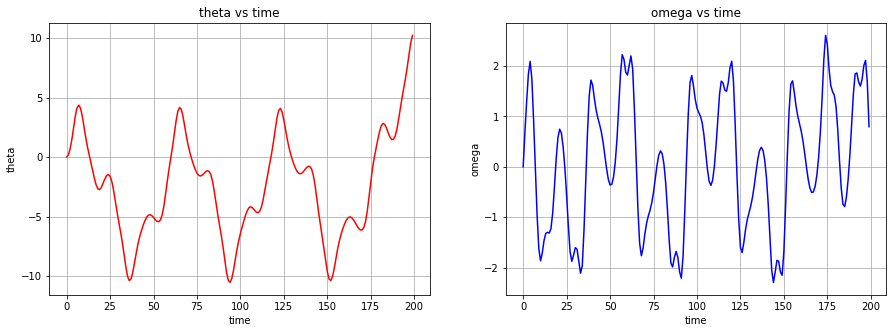

In [4]:
# initial parameters
theta0 = w0 = 0
Q = 2.0
d = 1.5
w = 0.65
X0 = (theta0, w0)
t = np.linspace(0, 100, 200)

def derivate(X, time, Q, d, w):
    return (X[1], -1/Q*X[1] + np.sin(X[0]) + d*np.cos(w*time))

X = odeint(derivate, X0, t, args=(Q, d, w))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15,5])
ax1.plot(X[:,0], c='red')
ax2.plot(X[:,1], c='blue')

ax1.set_xlabel('time')
ax1.set_ylabel('theta')
ax1.set_title('theta vs time')
ax1.grid()
ax2.set_xlabel('time')
ax2.set_ylabel('omega')
ax2.set_title('omega vs time')
ax2.grid()

plt.show()

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`

In [5]:
!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/

--2023-12-15 17:52:07--  https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt
Resolving www.dropbox.com... 162.125.69.18
Connecting to www.dropbox.com|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ebe1cnyd2gm836a/populations.txt [following]
--2023-12-15 17:52:07--  https://www.dropbox.com/s/raw/ebe1cnyd2gm836a/populations.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd97546a804216b3acc59592080.dl.dropboxusercontent.com/cd/0/inline/CJf7Zf1S-4YOCSE2A02sBVciqJlM2ewjcVougQbx_xybHuXTuumxQ_fQtyZjoDvUKNIT-Wypz5xiTDhpXOLtDQjih6_lpfIrjku6E4ZuUyGL33SP5lxiH8SKy0JkjZIk5Q4/file# [following]
--2023-12-15 17:52:07--  https://ucd97546a804216b3acc59592080.dl.dropboxusercontent.com/cd/0/inline/CJf7Zf1S-4YOCSE2A02sBVciqJlM2ewjcVougQbx_xybHuXTuumxQ_fQtyZjoDvUKNIT-Wypz5xiTDhpXOLtDQjih6_lpfIrjku6E4ZuUyGL33SP5lxiH8SKy0JkjZIk5Q4/file
Resolving ucd97546a804216b3acc59592080.

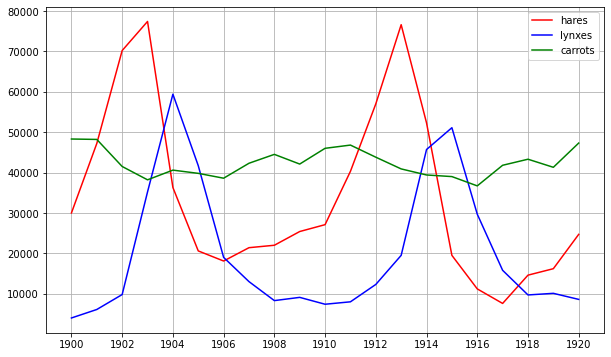

Hares:
By inspection of the plot, there are two maxs in: 1903 and 1913
So, the period should be of: 10 years

Lynxes:
By inspection of the plot, there are two maxs in: 1904 and 1915
So, the period should be of: 11 years



In [6]:
# data
data = np.loadtxt('data/populations.txt')
year, hares, lynxes, carrots = data.T

# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt1 = ax.plot(year, hares, c='r')
plt2 = ax.plot(year, lynxes, c='b')
plt3 = ax.plot(year, carrots, c='g')
ax.legend(['hares', 'lynxes', 'carrots'])
ax.grid()
plt.xticks(np.arange(min(year), max(year)+1, 2))
plt.show()

# maxs of hares
max1_h = list(hares).index(max(hares[:10]))
max2_h = list(hares).index(max(hares[10:]))
print('Hares:')
print('By inspection of the plot, there are two maxs in:', max1_h+1900, 'and', max2_h+1900)
print('So, the period should be of:', max2_h-max1_h, 'years\n')
# maxs of lynxes
max1_l = list(lynxes).index(max(lynxes[:10]))
max2_l = list(lynxes).index(max(lynxes[10:]))
print('Lynxes:')
print('By inspection of the plot, there are two maxs in:', max1_l+1900, 'and', max2_l+1900)
print('So, the period should be of:', max2_l-max1_l, 'years\n')

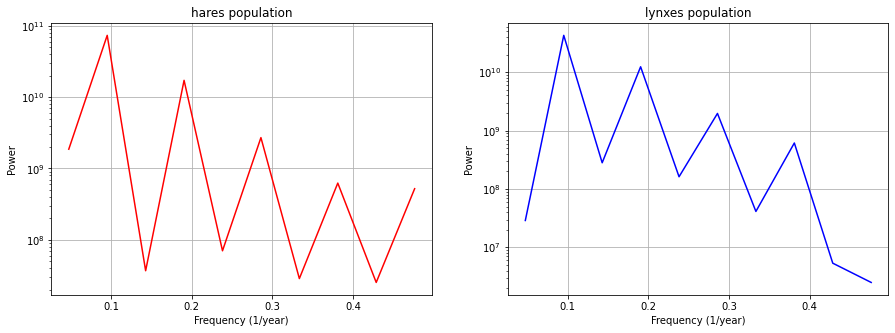

The evolution period is for both the populations of 1/1.1 = 10 years approximately.


In [7]:
# hares

# fourier transofrm and spectral density
hares_fft = fftpack.fft(hares)
# power spectral density
hares_psd = np.abs(hares_fft)**2
# frequencies (it is already in years)
fftfreq = fftpack.fftfreq(len(hares_psd))
# consider only the real part of the signal
i = fftfreq > 0
#plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15,5])
ax1.plot(fftfreq[i], hares_psd[i], c='r')
ax1.set_title('hares population')
ax1.set_xlabel('Frequency (1/year)')
ax1.set_ylabel('Power')
ax1.set_yscale('log')
ax1.grid()



# lynxes

# fourier transofrm and spectral density
lynxes_fft = fftpack.fft(lynxes)
# power spectral density
lynxes_psd = np.abs(lynxes_fft)**2
#plot
ax2.plot(fftfreq[i], lynxes_psd[i], c='b')
ax2.set_title('lynxes population')
ax2.set_xlabel('Frequency (1/year)')
ax2.set_ylabel('Power')
ax2.set_yscale('log')
ax2.grid()

plt.show()

print('The evolution period is for both the populations of 1/1.1 = 10 years approximately.')

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

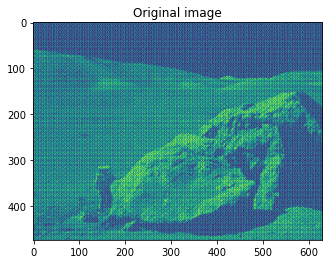

In [8]:
# read and show the image with the noise
image = plt.imread("images/moonlanding.png")
plt.imshow(image)
plt.title('Original image')

plt.show()

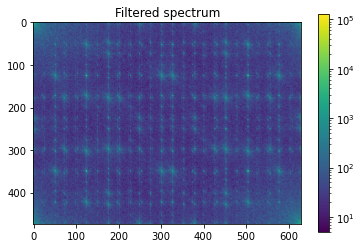

In [9]:
# fourier transform
ft = fftpack.fft2(image)
power = np.abs(ft) # absolute value
plt.imshow(power, norm=LogNorm(vmin=5))
plt.colorbar()
plt.title('Filtered spectrum')

plt.show()

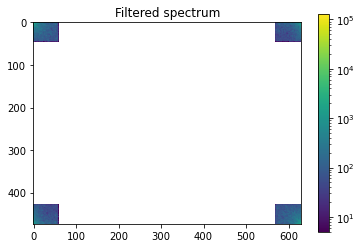

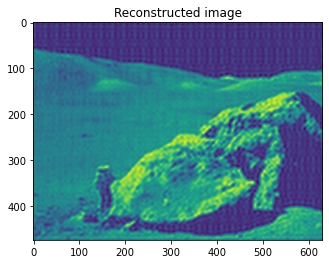

In [10]:
ft2 = ft.copy()
r, c = ft2.shape
keep_fraction = 0.095

# keep only the angles
ft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
ft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0

# filtered spectrum
plt.figure()
plt.imshow(np.abs(ft2), norm=LogNorm(vmin=5))
plt.colorbar()
plt.title('Filtered spectrum')

# reconstructed image
im_rec = fftpack.ifft2(ft2).real
plt.figure()
plt.imshow(im_rec)
plt.title('Reconstructed image')

plt.show()